In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping


In [2]:
# Hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

key = jax.random.PRNGKey(SEED)


In [4]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=False,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=False,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)


In [5]:
# Checking our data a bit (by now, everyone knows what the MNIST dataset looks like)
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x1x28x28
print(dummy_y.shape)  # 64
print(dummy_y)


(64, 1, 28, 28)
(64,)
[3 6 7 5 7 7 3 0 4 0 2 4 0 7 2 9 8 6 8 8 2 2 9 3 4 3 1 0 8 6 7 4 9 3 4 6 3
 9 5 1 4 3 1 9 9 6 0 3 2 0 3 5 9 2 1 9 5 9 2 3 3 3 0 7]


In [6]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(1, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key2),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x


key, subkey = jax.random.split(key, 2)
model = CNN(subkey)


In [7]:
def loss(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    # Our input has the shape (BATCH_SIZE, 1, 28, 28), but our model operations on
    # a single input input image of shape (1, 28, 28).
    #
    # Therefore, we have to use jax.vmap, which in this case maps our model over the
    # leading (batch) axis.
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


# Example loss
loss_value = loss(model, dummy_x, dummy_y)
print(loss_value.shape)  # scalar loss
# Example inference
output = jax.vmap(model)(dummy_x)
print(output.shape)  # batch of predictions


()
(64, 10)


In [9]:
loss(model, dummy_x, dummy_y)

Array(2.3019257, dtype=float32)

In [10]:
# This will work!
params, static = eqx.partition(model, eqx.is_array)


def loss2(params, static, x, y):
    model = eqx.combine(params, static)
    return loss(model, x, y)


loss_value, grads = jax.value_and_grad(loss2)(params, static, dummy_x, dummy_y)
print(loss_value)


2.3392458


In [12]:
# This will work too!
value, grads = eqx.filter_value_and_grad(loss)(model, dummy_x, dummy_y)
print(value)


2.3392458


In [13]:
loss = eqx.filter_jit(loss)  # JIT our loss function from earlier!


@eqx.filter_jit
def compute_accuracy(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    """This function takes as input the current model
    and computes the average accuracy on a batch.
    """
    pred_y = jax.vmap(model)(x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)


In [14]:
def evaluate(model: CNN, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    avg_acc = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
        avg_acc += compute_accuracy(model, x, y)
    return avg_loss / len(testloader), avg_acc / len(testloader)


In [16]:
evaluate(model, testloader)


(Array(2.3078535, dtype=float32), Array(0.10111465, dtype=float32))

In [17]:
optim = optax.adamw(LEARNING_RATE)


In [18]:
def train(
    model: CNN,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
) -> CNN:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: CNN,
        opt_state: PyTree,
        x: Float[Array, "batch 1 28 28"],
        y: Int[Array, " batch"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss, test_accuracy = evaluate(model, testloader)
            print(
                f"{step=}, train_loss={train_loss.item()}, "
                f"test_loss={test_loss.item()}, test_accuracy={test_accuracy.item()}"
            )
    return model


In [19]:
model = train(model, trainloader, testloader, optim, STEPS, PRINT_EVERY)

step=0, train_loss=2.3045878410339355, test_loss=2.306015968322754, test_accuracy=0.10579219460487366
step=30, train_loss=2.1392531394958496, test_loss=2.1244659423828125, test_accuracy=0.4166998267173767
step=60, train_loss=1.6854264736175537, test_loss=1.7574509382247925, test_accuracy=0.6382364630699158
step=90, train_loss=1.4006105661392212, test_loss=1.3252055644989014, test_accuracy=0.6492834687232971
step=120, train_loss=0.777535080909729, test_loss=0.9569195508956909, test_accuracy=0.7956807613372803
step=150, train_loss=0.603909432888031, test_loss=0.7198020815849304, test_accuracy=0.831409215927124
step=180, train_loss=0.7552712559700012, test_loss=0.5840596556663513, test_accuracy=0.8567874431610107
step=210, train_loss=0.5615401864051819, test_loss=0.5071444511413574, test_accuracy=0.8623606562614441
step=240, train_loss=0.345998615026474, test_loss=0.4376766085624695, test_accuracy=0.887340784072876
step=270, train_loss=0.38446852564811707, test_loss=0.39942917227745056, t

In [20]:
XX, yy = next(iter(trainloader))

In [29]:
import matplotlib.pyplot as plt

In [31]:
test_digit = jnp.array(test_dataset[0][0])[0]

In [37]:
jnp.argmax(model(jnp.array(test_dataset[0][0])))

Array(7, dtype=int32)

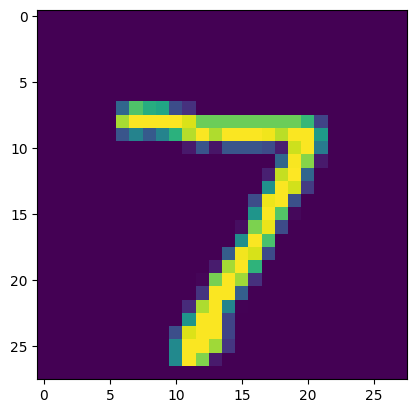

In [30]:
plt.imshow(jnp.array(test_dataset[0][0])[0])